# Imports

In [1]:
from copy import deepcopy
import sys
import cv2
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex
from tqdm import tqdm
import albumentations as A
from hydra import initialize, compose
import matplotlib.pyplot as plt

/home/panos/dev/hf_seg/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Add the project root directory to the Python path
cur_dir     = Path.cwd()
project_dir = cur_dir.parent
sys.path.append(str(project_dir))

from models.DinoFPNbn import DinoFPN
from models.tools import CombinedLoss
from src.validate import evaluate_model
from src.train import train_and_validate
from data.kitti360.dataset import KittiSemSegDataset
from utils.others import save_checkpoint, load_checkpoint, get_memory_footprint

Using device: cuda
Using device: cuda


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
with initialize(version_base=None, config_path=f"../configs", job_name="train_and_log"):
    cfg = compose(config_name="prune_config")

# Set up model and dataloaders

In [5]:
model = DinoFPN(
    cfg.dataset.num_classes, 
    cfg.model
)

In [6]:
# Load the base model
ckpt_path = project_dir / "checkpoints" / "dino-fpn-bn.pth"
if not ckpt_path.exists():
    print(f"[Error] Checkpoint not found: {ckpt_path}")
checkpoint = torch.load(ckpt_path, map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Loaded FP32 weights from {ckpt_path} into fp32_model.")

Loaded FP32 weights from /home/panos/dev/hf_seg/checkpoints/dino-fpn-bn.pth into fp32_model.


In [7]:
total_params, total_bytes = get_memory_footprint(model, detailed=True)

=== Model Memory Footprint ===
Backbone: 86,580,480 params, 330.28 MB
Head:     3,747,617 params, 14.30 MB
Total:    90,328,097 params, 344.57 MB


In [8]:
crop_size = (cfg.augmentation.crop_height, cfg.augmentation.crop_width)
train_transform = A.Compose([
    # -- Geometric --
    A.RandomCrop(height=crop_size[0], width=crop_size[1], p=1.0), # preserve scale/context
    A.Affine(
        # translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, # ±5% shift
        scale=(0.8, 1.0),                                           # zoom between 0.8×–1.0×
        rotate=(-3, 3),                                             # ±3° roll
        interpolation=cv2.INTER_LINEAR,
        mask_interpolation=cv2.INTER_NEAREST,
        border_mode=cv2.BORDER_CONSTANT,
        fill=255,
        fill_mask=255,
        p=0.7
    ),
    A.Perspective(scale=(0.01, 0.03), p=0.5),  # tiny camera viewpoint warp

    # -- Photometric --
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    A.RandomGamma(gamma_limit=(90, 110), p=0.5),
    A.OneOf([
        A.RandomFog(fog_coef_range=(0.05, 0.2), p=1.0),
        A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_limit=(1, 2), p=1.0),
        A.RandomSunFlare(src_radius=50, p=1.0)
    ], p=0.5),

    # -- Occlusions --
    A.CoarseDropout(num_holes_range=(1, 4), 
                    hole_height_range=(5, 30), 
                    hole_width_range=(5, 30), 
                    p=0.5),                                # random occlusion

    # — Blur & noise: motion, sensor, compression —
    A.OneOf([
        A.MotionBlur(blur_limit=5, p=0.4),
        A.GaussianBlur(blur_limit=(3,5), p=0.3),
        A.MedianBlur(blur_limit=3, p=0.2),
    ], p=0.5),
    A.GaussNoise(
        std_range=(10.0/255.0, 50.0/255.0),
        mean_range=(0.0, 0.0),
        p=0.5
    )
])

# Define deterministic transforms for validation
val_transform = A.Compose([
    A.CenterCrop(height=crop_size[0], width=crop_size[1])
])

In [9]:
# Dataset and DataLoader
dataset_root = '/home/panos/Documents/data/kitti-360'
train_dataset = KittiSemSegDataset(dataset_root, train=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=cfg.train.batch_size, 
                            shuffle=True, num_workers=cfg.dataset.num_workers, pin_memory=True)
val_dataset = KittiSemSegDataset(dataset_root, train=False, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=cfg.train.batch_size,
                        shuffle=False, num_workers=cfg.dataset.num_workers, pin_memory=True)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 7042
Validation dataset size: 783


# Analyze model

In [10]:
total_params = 0
sparse_params = 0

for name, module in model.named_modules():
    if hasattr(module, 'weight'):
        total_params += module.weight.numel()
        sparse_params += (module.weight == 0).sum().item()

print(f"Total parameters: {total_params}")
print(f"Sparse parameters: {sparse_params}")
sparsity = 100 * sparse_params / total_params
print(f"Model sparsity: {sparsity:.2f}%")

Total parameters: 89150976
Sparse parameters: 0
Model sparsity: 0.00%


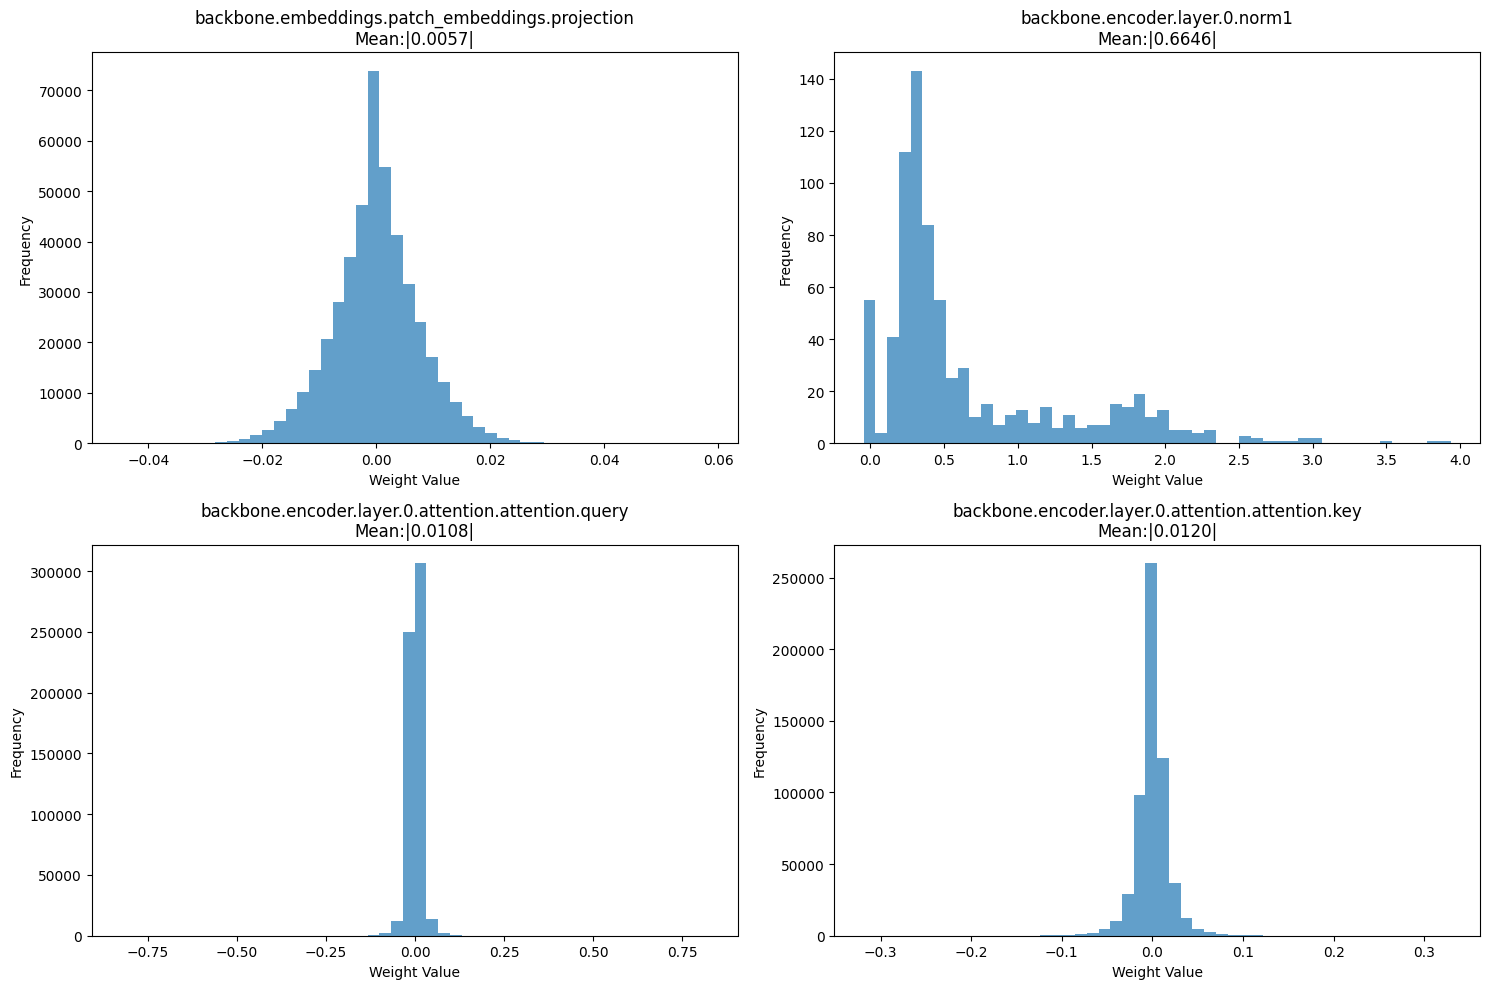

backbone.embeddings.patch_embeddings.projection | Mean:|0.0057| | Near-zero: 2.2%
backbone.encoder.layer.0.norm1 | Mean:|0.6646| | Near-zero: 0.0%
backbone.encoder.layer.0.attention.attention.query | Mean:|0.0108| | Near-zero: 1.0%
backbone.encoder.layer.0.attention.attention.key | Mean:|0.0120| | Near-zero: 0.9%
backbone.encoder.layer.0.attention.attention.value | Mean:|0.0092| | Near-zero: 1.3%
backbone.encoder.layer.0.attention.output.dense | Mean:|0.0086| | Near-zero: 1.1%
backbone.encoder.layer.0.norm2 | Mean:|1.4835| | Near-zero: 0.1%
backbone.encoder.layer.0.mlp.fc1 | Mean:|0.0124| | Near-zero: 0.7%
backbone.encoder.layer.0.mlp.fc2 | Mean:|0.0106| | Near-zero: 0.7%
backbone.encoder.layer.1.norm1 | Mean:|1.2084| | Near-zero: 0.0%
backbone.encoder.layer.1.attention.attention.query | Mean:|0.0146| | Near-zero: 0.5%
backbone.encoder.layer.1.attention.attention.key | Mean:|0.0151| | Near-zero: 0.5%
backbone.encoder.layer.1.attention.attention.value | Mean:|0.0116| | Near-zero: 0.7%
b

In [11]:
def analyze_weight_magnitudes(model):
    """Inspect weight distributions across layers"""    
    weight_stats = {}
    
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and module.weight is not None:
            weights = module.weight.data.flatten()
            
            # Get actual weights (handles both pruned and unpruned)
            if hasattr(module, 'weight_orig'):
                # Pruned layer - use original weights masked
                weights = module.weight.data.flatten()  # This is already masked
            else:
                # Unpruned layer - use weights directly
                weights = module.weight.data.flatten()
            
            weight_stats[name] = {
                'mean_abs': weights.abs().mean().item(),
                'std': weights.std().item(),
                'zeros': (weights == 0).sum().item(),
                'near_zeros': (weights.abs() < 1e-4).sum().item(),
                'total': weights.numel()
            }
    
    # Plot weight distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    layer_names = list(weight_stats.keys())[:8]  # First 8 layers
    
    for i, name in enumerate(layer_names):
        if i >= 4: break
        ax = axes[i//2, i%2]
        
        # Get the actual module and its weights
        module = dict(model.named_modules())[name]
        weights = module.weight.data.flatten()
        
        ax.hist(weights.cpu().numpy(), bins=50, alpha=0.7)
        ax.set_title(f"{name}\nMean:|{weight_stats[name]['mean_abs']:.4f}|")
        ax.set_xlabel("Weight Value")
        ax.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()
    
    return weight_stats

# Analyze your model
weight_stats = analyze_weight_magnitudes(model)

# Print summary
for name, stats in weight_stats.items():
    near_zero_pct = 100 * stats['near_zeros'] / stats['total']
    print(f"{name:30} | Mean:|{stats['mean_abs']:.4f}| | Near-zero: {near_zero_pct:.1f}%")

# Perform Global Pruning

*Unstructured pruning*
- A 30% lowest magnitude global pruning drops the validation mIoU from 85% to 26%
- A 15% lowest magnitude global pruning drops the validation mIoU from 85% to 80%

- Unstructured pruning doesn't decrease model size or reduce inference time due to the fact that I have an old GPU that doesn't support sparse matrix multiplication. However, in newer GPUs, the inference time improvement would likely be significant.

*Structured pruning*
- A 30% lowest magnitude global pruning drops the validation mIoU from 85% to 0% (expectedly)

- Structured pruning also doesn't decrease model size because PyTorch does not actually remove the pruned channels/features, it just adds a weight/bias mask

## Unstructured pruning

### Prune model

In [12]:
u_pruned_model = deepcopy(model)

In [13]:
def apply_global_pruning(model, pruning_ratio=0.3, exclude_layers=True):
    """Global pruning with critical layer protection"""
    
    parameters_to_prune = []
    excluded_layers = []
    
    for name, module in model.named_modules():
        if hasattr(module, 'weight') and module.weight is not None:
            # Exclude critical layers
            if exclude_layers:
                if any(exclude in name for exclude in ['norm', 'BatchNorm2d', 'layernorm', 'classifier.4']) or \
                isinstance(module, (torch.nn.BatchNorm2d, torch.nn.LayerNorm, torch.nn.GroupNorm, torch.nn.Dropout)):
                    excluded_layers.append(name)
                    continue
            
            parameters_to_prune.append((module, 'weight'))
    
    print(f"Pruning {len(parameters_to_prune)} layers")
    for name, module in parameters_to_prune:
        print(f"  - {name}.{module}")
    print(f"Excluded {len(excluded_layers)} critical layers:")
    for layer in excluded_layers:
        print(f"  - {layer}")
    
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_ratio,
    )
    
    return model

apply_global_pruning(u_pruned_model, pruning_ratio=0.30, exclude_layers=True)

Pruning 79 layers
  - Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14)).weight
  - Linear(in_features=768, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=3072, bias=True).weight
  - Linear(in_features=3072, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=3072, bias=True).weight
  - Linear(in_features=3072, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=768, bias=True).weight
  - Linear(in_features=768, out_features=768, bias=True).weight
  - Linear(in_fea

DinoFPN(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerScale()
          

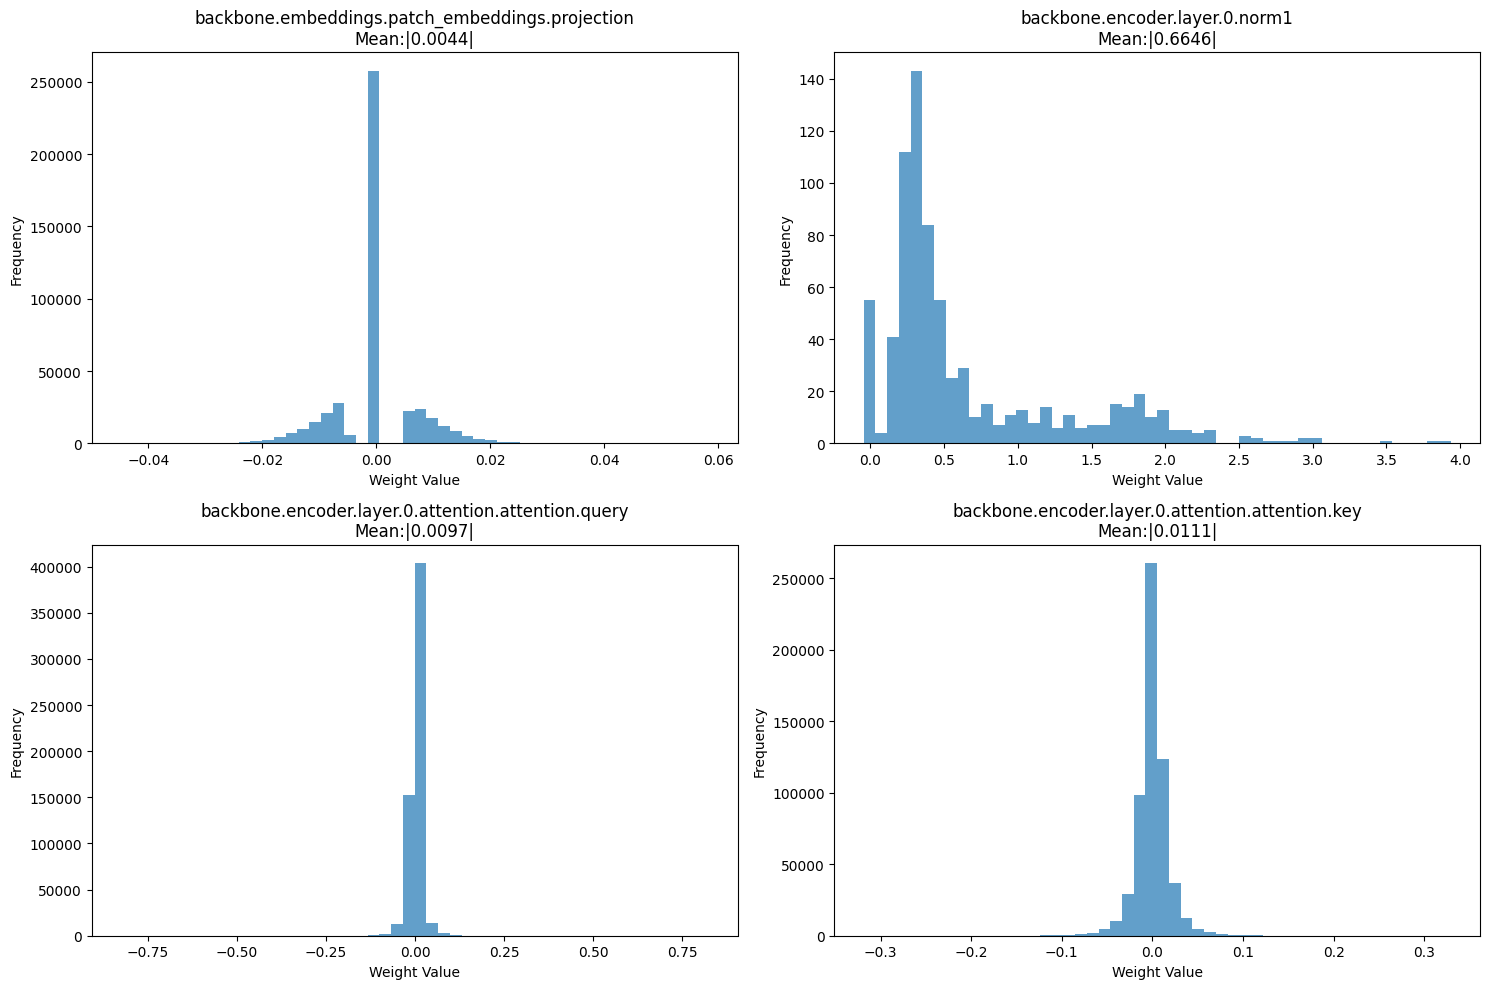

backbone.embeddings.patch_embeddings.projection | Mean:|0.0057| | Near-zero: 2.2%
backbone.encoder.layer.0.norm1 | Mean:|0.6646| | Near-zero: 0.0%
backbone.encoder.layer.0.attention.attention.query | Mean:|0.0108| | Near-zero: 1.0%
backbone.encoder.layer.0.attention.attention.key | Mean:|0.0120| | Near-zero: 0.9%
backbone.encoder.layer.0.attention.attention.value | Mean:|0.0092| | Near-zero: 1.3%
backbone.encoder.layer.0.attention.output.dense | Mean:|0.0086| | Near-zero: 1.1%
backbone.encoder.layer.0.norm2 | Mean:|1.4835| | Near-zero: 0.1%
backbone.encoder.layer.0.mlp.fc1 | Mean:|0.0124| | Near-zero: 0.7%
backbone.encoder.layer.0.mlp.fc2 | Mean:|0.0106| | Near-zero: 0.7%
backbone.encoder.layer.1.norm1 | Mean:|1.2084| | Near-zero: 0.0%
backbone.encoder.layer.1.attention.attention.query | Mean:|0.0146| | Near-zero: 0.5%
backbone.encoder.layer.1.attention.attention.key | Mean:|0.0151| | Near-zero: 0.5%
backbone.encoder.layer.1.attention.attention.value | Mean:|0.0116| | Near-zero: 0.7%
b

In [14]:
pruned_weight_stats = analyze_weight_magnitudes(u_pruned_model)

# Print summary
for name, stats in weight_stats.items():
    near_zero_pct = 100 * stats['near_zeros'] / stats['total']
    print(f"{name:30} | Mean:|{stats['mean_abs']:.4f}| | Near-zero: {near_zero_pct:.1f}%")

### Evaluate the pruned model

In [15]:
dataset_root = '/home/panos/Documents/data/kitti-360'
val_transform = A.Compose([A.CenterCrop(crop_size[0], crop_size[1])])
val_dataset = KittiSemSegDataset(dataset_root, train=False, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=cfg.dataset.num_workers, pin_memory=True)
criterion = CombinedLoss(alpha=0.8, ignore_index=255)
optimizer = optim.Adam(u_pruned_model.parameters(), lr=cfg.train.learning_rate)

# Metric: mean IoU over all classes
miou_metric = JaccardIndex(
    task='multiclass',
    num_classes=cfg.dataset.num_classes,
    average='micro',
    ignore_index=255
).to(device)
u_pruned_model = u_pruned_model.to(device)

In [14]:
val_miou = evaluate_model(u_pruned_model, val_loader, criterion, miou_metric, device="cuda")

100%|██████████| 196/196 [05:53<00:00,  1.81s/it]


  Val   Loss: 0.4578 | mIoU: 0.8030


### Re-train the pruned model to recover mIoU

In [16]:
# Check if the backbone is frozen
if not any(p.requires_grad for p in u_pruned_model.backbone.parameters()):
    print("Backbone is frozen.")
if not any(p.requires_grad for p in u_pruned_model.head.parameters()):
    print("Head is frozen.")

Backbone is frozen.


In [17]:
cfg.checkpoint

{'model_name': 'pruned', 'comment': 'unstructured pruning'}

In [ ]:
# Save the pruned model to a checkpoint to train later using the "prune.py" script
save_checkpoint(
    u_pruned_model, 
    optimizer, 
    save_path=project_dir / "checkpoints" / "pruned.pth",
    epoch=0,
    best_val_miou=0.26,
    checkpoint_cfg=cfg.checkpoint
)

Checkpoint saved in /home/panos/dev/hf_seg/checkpoints/pruned.pth at epoch 0 with mIoU=0.2600


## Structured pruning

### Prune model

In [64]:
# PyTorch performs pseudo-pruning, which doesn't reduce the model size on disk.
def global_structured_pruning(original_model, pruning_ratio=0.3):
    model = deepcopy(original_model)
    print(f"Starting uniform structured pruning ({pruning_ratio:.0%})...")
    pruned_layers = 0
    total_original_params = 0
    total_pruned_params = 0
    
    for name, module in model.named_modules():
        should_prune = False
        layer_type = ""
        
        if isinstance(module, torch.nn.Conv2d):
            should_prune = True
            layer_type = "Conv2d"
        elif isinstance(module, torch.nn.Linear) and 'attention' in name:
            should_prune = True
            layer_type = "Attention"
        
        if should_prune and hasattr(module, 'weight'):
            # Get original channel count
            original_channels = module.weight.shape[0]
            
            # Apply structured pruning
            prune.ln_structured(
                module,
                name='weight',
                amount=pruning_ratio,
                n=1,  # L1 norm
                dim=0  # Output channels
            )
            
            # Calculate pruned channels
            pruned_channels = int(original_channels * pruning_ratio)
            
            total_original_params += original_channels
            total_pruned_params += pruned_channels
            pruned_layers += 1
            
            print(f"{name:50} ({layer_type:8}) | Pruned: {pruned_channels:3d}/{original_channels:3d} ({pruning_ratio*100:5.1f}%)")
            prune.remove(module, 'weight')

    actual_ratio = total_pruned_params / total_original_params if total_original_params > 0 else 0
    print(f"\nPruned {pruned_layers} layers")
    print(f"Overall pruning ratio: {actual_ratio:.1%}")
    print(f"Total channels pruned: {total_pruned_params:,}/{total_original_params:,}")
    
    return model

# Apply 30% global structured pruning to Conv2d and attention layers
s_pruned_model = global_structured_pruning(model, pruning_ratio=0.3)

Starting uniform structured pruning (30%)...
backbone.embeddings.patch_embeddings.projection    (Conv2d  ) | Pruned: 230/768 ( 30.0%)
backbone.encoder.layer.0.attention.attention.query (Attention) | Pruned: 230/768 ( 30.0%)
backbone.encoder.layer.0.attention.attention.key   (Attention) | Pruned: 230/768 ( 30.0%)
backbone.encoder.layer.0.attention.attention.value (Attention) | Pruned: 230/768 ( 30.0%)
backbone.encoder.layer.0.attention.output.dense    (Attention) | Pruned: 230/768 ( 30.0%)
backbone.encoder.layer.1.attention.attention.query (Attention) | Pruned: 230/768 ( 30.0%)
backbone.encoder.layer.1.attention.attention.key   (Attention) | Pruned: 230/768 ( 30.0%)
backbone.encoder.layer.1.attention.attention.value (Attention) | Pruned: 230/768 ( 30.0%)
backbone.encoder.layer.1.attention.output.dense    (Attention) | Pruned: 230/768 ( 30.0%)
backbone.encoder.layer.2.attention.attention.query (Attention) | Pruned: 230/768 ( 30.0%)
backbone.encoder.layer.2.attention.attention.key   (Atte

In [65]:
total_params, total_bytes = get_memory_footprint(model, detailed=True)
total_params, total_bytes = get_memory_footprint(s_pruned_model, detailed=True)

=== Model Memory Footprint ===
Backbone: 86,580,480 params, 330.28 MB
Head:     3,747,617 params, 14.30 MB
Total:    90,328,097 params, 344.57 MB
=== Model Memory Footprint ===
Backbone: 86,580,480 params, 330.28 MB
Head:     3,747,617 params, 14.30 MB
Total:    90,328,097 params, 344.57 MB


### Evaluate pruned model

In [67]:
dataset_root = '/home/panos/Documents/data/kitti-360'
val_transform = A.Compose([A.CenterCrop(crop_size[0], crop_size[1])])
val_dataset = KittiSemSegDataset(dataset_root, train=False, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=cfg.dataset.num_workers, pin_memory=True)
criterion = CombinedLoss(alpha=0.8, ignore_index=255)
optimizer = optim.Adam(s_pruned_model.parameters(), lr=cfg.train.learning_rate)

# Metric: mean IoU over all classes
miou_metric = JaccardIndex(
    task='multiclass',
    num_classes=cfg.dataset.num_classes,
    average='micro',
    ignore_index=255
).to(device)
s_pruned_model = s_pruned_model.to(device)

In [68]:
evaluate_model(s_pruned_model, val_loader, criterion, miou_metric, device="cuda")

100%|██████████| 196/196 [05:48<00:00,  1.78s/it]


  Val   Loss: 3.0597 | mIoU: 0.0032


### Prune without replacement (experimental)

This part is just some experimentation for how we can perform structured prunning while actually removing the prunned weights/biases, thus significantly reducing the model size:

- 30% model pruning reduces the model size from 344 MB to 38 MB
- 90% model pruning reduces the model size from 344 MB to 242 MB

**However**, the forward pass actually fails during evaluation, as replacing the layers isn't as straight-forward.
For example, often the input shape of a linear layer depends on the ouput shape of the one before. It requires more careful hand-crafting.

In [87]:
def prune_and_shrink(original_model, pruning_ratio=0.3):
    model = deepcopy(original_model)

    # First: apply structured pruning as before
    for name, module in model.named_modules():
        is_conv = isinstance(module, nn.Conv2d)
        is_attn = isinstance(module, nn.Linear) #and 'attention' in name
        if not (is_conv or is_attn) or name == 'head.classifier.4':
            continue

        prune.ln_structured(
            module, 'weight',
            amount=pruning_ratio,
            n=1,
            dim=0
        )
        # make the mask permanent
        prune.remove(module, 'weight')

    # Helper to find & replace submodules by name
    def replace_module(parent, attr, new_module):
        print(f"    Replacing {attr} in {parent.__class__.__name__} with {new_module.__class__.__name__}")
        setattr(parent, attr, new_module)

    print(f"Starting structured pruning and shrinking ({pruning_ratio:.0%})...")
    # Second: rebuild each pruned layer smaller
    for name, module in list(model.named_modules()):
        print(f"Processing {name} with type {module.__class__.__name__}")
        is_conv = isinstance(module, nn.Conv2d)
        is_lin = isinstance(module, nn.Linear) #and 'attention' in name
        if (is_conv or is_lin) and name != 'head.classifier.4':
            print(f"Pruning {name} ({'Conv2d' if is_conv else 'Linear'})...")
            # Get surviving indices: output-channels (dim=0) whose weights are nonzero
            if is_conv:
                # sum absolute weights over (in_channels, H, W)
                mask = module.weight.data.abs().sum(dim=(1,2,3)) != 0
            else:
                # for Linear, sum over input dim
                mask = module.weight.data.abs().sum(dim=1) != 0

            keep_idx = torch.nonzero(mask, as_tuple=False).flatten().cpu().tolist()
            print(f"  Surviving indices: {len(keep_idx)} out of {module.out_features if is_lin else module.out_channels}")
            # nothing was pruned here (e.g. rounding), skip
            if is_lin and len(keep_idx) == module.out_features:
                continue
            if is_conv and len(keep_idx) == module.out_channels:
                continue

            # Build a new module of reduced size
            if is_conv:
                new_mod = nn.Conv2d(
                    in_channels=module.in_channels,
                    out_channels=len(keep_idx),
                    kernel_size=module.kernel_size,
                    stride=module.stride,
                    padding=module.padding,
                    dilation=module.dilation,
                    groups=module.groups,
                    bias=(module.bias is not None),
                )
                # copy over surviving filters
                new_mod.weight.data = module.weight.data[keep_idx].clone()
                if module.bias is not None:
                    new_mod.bias.data   = module.bias.data[keep_idx].clone()
            else:  # Linear attention
                new_mod = nn.Linear(
                    in_features=module.in_features,
                    out_features=len(keep_idx),
                    bias=(module.bias is not None),
                )
                new_mod.weight.data = module.weight.data[keep_idx].clone()
                if module.bias is not None:
                    new_mod.bias.data   = module.bias.data[keep_idx].clone()

            # Locate the parent module and replace
            path = name.split('.')
            parent = model
            for p in path[:-1]:
                parent = getattr(parent, p)
            replace_module(parent, path[-1], new_mod)

    return model

In [88]:
s2_pruned_model = prune_and_shrink(model, pruning_ratio=0.3)
total_params, total_bytes = get_memory_footprint(model, detailed=True)
total_params, total_bytes = get_memory_footprint(s2_pruned_model, detailed=True)

Starting structured pruning and shrinking (30%)...
Processing  with type DinoFPN
Processing backbone with type Dinov2Model
Processing backbone.embeddings with type Dinov2Embeddings
Processing backbone.embeddings.patch_embeddings with type Dinov2PatchEmbeddings
Processing backbone.embeddings.patch_embeddings.projection with type Conv2d
Pruning backbone.embeddings.patch_embeddings.projection (Conv2d)...
  Surviving indices: 538 out of 768
    Replacing projection in Dinov2PatchEmbeddings with Conv2d
Processing backbone.embeddings.dropout with type Dropout
Processing backbone.encoder with type Dinov2Encoder
Processing backbone.encoder.layer with type ModuleList
Processing backbone.encoder.layer.0 with type Dinov2Layer
Processing backbone.encoder.layer.0.norm1 with type LayerNorm
Processing backbone.encoder.layer.0.attention with type Dinov2Attention
Processing backbone.encoder.layer.0.attention.attention with type Dinov2SelfAttention
Processing backbone.encoder.layer.0.attention.attention

In [89]:
s1_pruned_model = prune_and_shrink(model, pruning_ratio=0.9)
total_params, total_bytes = get_memory_footprint(model, detailed=True)
total_params, total_bytes = get_memory_footprint(s1_pruned_model, detailed=True)

Starting structured pruning and shrinking (90%)...
Processing  with type DinoFPN
Processing backbone with type Dinov2Model
Processing backbone.embeddings with type Dinov2Embeddings
Processing backbone.embeddings.patch_embeddings with type Dinov2PatchEmbeddings
Processing backbone.embeddings.patch_embeddings.projection with type Conv2d
Pruning backbone.embeddings.patch_embeddings.projection (Conv2d)...
  Surviving indices: 77 out of 768
    Replacing projection in Dinov2PatchEmbeddings with Conv2d
Processing backbone.embeddings.dropout with type Dropout
Processing backbone.encoder with type Dinov2Encoder
Processing backbone.encoder.layer with type ModuleList
Processing backbone.encoder.layer.0 with type Dinov2Layer
Processing backbone.encoder.layer.0.norm1 with type LayerNorm
Processing backbone.encoder.layer.0.attention with type Dinov2Attention
Processing backbone.encoder.layer.0.attention.attention with type Dinov2SelfAttention
Processing backbone.encoder.layer.0.attention.attention.

### Evaluate pruned model

In [90]:
model

DinoFPN(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerScale()
          

In [91]:
s2_pruned_model

DinoFPN(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 538, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=538, bias=True)
              (key): Linear(in_features=768, out_features=538, bias=True)
              (value): Linear(in_features=768, out_features=538, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=538, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerScale()
          

In [92]:
dataset_root = '/home/panos/Documents/data/kitti-360'
val_transform = A.Compose([A.CenterCrop(crop_size[0], crop_size[1])])
val_dataset = KittiSemSegDataset(dataset_root, train=False, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=cfg.dataset.num_workers, pin_memory=True)
criterion = CombinedLoss(alpha=0.8, ignore_index=255)
optimizer = optim.Adam(s1_pruned_model.parameters(), lr=cfg.train.learning_rate)

# Metric: mean IoU over all classes
miou_metric = JaccardIndex(
    task='multiclass',
    num_classes=cfg.dataset.num_classes,
    average='micro',
    ignore_index=255
).to(device)
s1_pruned_model = s1_pruned_model.to(device)

In [73]:
evaluate_model(s1_pruned_model, val_loader, criterion, miou_metric, device="cuda")

  0%|          | 0/196 [00:00<?, ?it/s]


RuntimeError: shape '[4, 2289, 12, 64]' is invalid for input of size 705012